In [1]:
%matplotlib inline
# notebook backend doesn't work on jupyterlab and widgets seems to die
# exclusively on binder, but works fine locally
# hence if you want interactivity in the plots:
# restart kernel, change the inline of the above to notebook and
# go to the notebook view via changing the url from
# https://hub.ovh2.mybinder.org/whatever/lab?
# to
# https://hub.ovh2.mybinder.org/whatever/tree/
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import glob
import matplotlib.patches as patches
import scipy
import scipy.sparse.linalg as linalg
import scipy.sparse as sparse
import random
import re
mpl.rcParams.update({'font.size': 10})
mpl.rcParams['figure.figsize'] = (8,4)  
X, Y = 0, 1
dirnames = {X: "X", Y: "Y"}
from helpers import *

First we need to determine the kind of packing we want to employ. There are a few quickly coded up packers in helpers.py, listed a few cells down with only one commented in; for those, set usedata = False and execute starting from here. If you want to use one of the packings based on the discrete element method, keep usedata = True and also execute from here on out.

In [2]:
usedata = True # False for regular/random packings, True if you want to use a pre-generated 3D packing

In [3]:
## this is for setting up regular/random packings generated via functions in helpers.py
# don't bother changing anything here if you have usedata = True
DIM=2 
numx = 5#10
numy = 7 #5 
totp = numx*numy
pos, rad, size = np.zeros((DIM, totp)), np.zeros(totp), np.zeros(totp)
# for reproducible packings you should set the seed via np.random.seed(seed), which is dirty and legacy
# but easy to do
#fillRandomCircles(pos, rad, totp, posamp=0.5)
fill2DChain(pos, rad, numx, numy=numy, theta=np.deg2rad(135))
#fillCircularChain(pos, rad, totp)
#fillRandomCircles_connected(pos, rad, totp)
if np.all(pos == 0):
    print("rerun before proceeding")

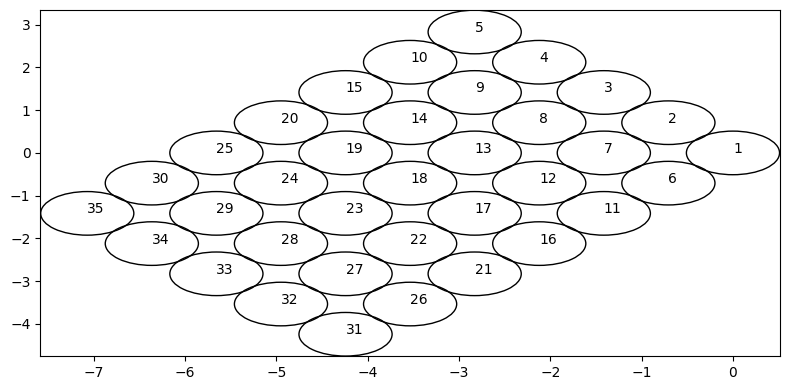

In [4]:
# quick 2D visualization of the packings w/ overlap
# this has limited applicability to the 3D packings, so it's above reading in those
fig, ax = plt.subplots()

#ax.scatter(pos[0], pos[1])
xmin, xmax = np.min(pos[0,:])-np.max(rad)*1.01, np.max(pos[0,:])+np.max(rad)*1.01
ymin, ymax = np.min(pos[1,:])-np.max(rad)*1.01, np.max(pos[1,:])+np.max(rad)*1.01
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

pps = range(totp) if totp < 200 else np.random.randint(0,totp,size=200)
for p in pps:
    #print(posen[0][p], posen[1][p], raden[p])
    pa = patches.Circle((pos[0][p], pos[1][p]), radius=rad[p], fill=False)
    ax.add_patch(pa)
    ax.annotate(str(p+1), (pos[0][p], pos[1][p])
               # , fontsize=30
               )
fig.tight_layout()

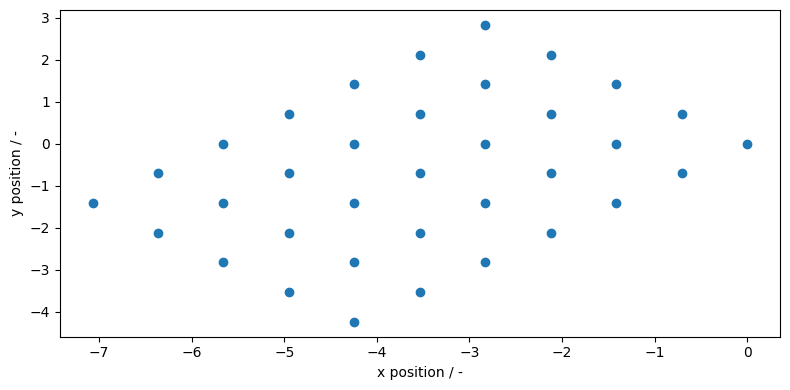

In [5]:
# minimal visualization with scatter
fig, ax = plt.subplots()
ax.set_xlabel("x position / -")
ax.set_ylabel("y position / -")
ax.scatter(pos[0], pos[1])
fig.tight_layout()

In [6]:
if usedata:
    sizen=400 # specify size of the packing; 200^3, 400^3 and 800^3 are within packs/
    homr=12 # voxelization radius; smaller -> more particles in the domain (8, 12, 16)
    DIM=3
    bpath = "packs/"
    spath = "mddata%d_r%d_1.dat" % (sizen, homr)
    paths = glob.glob(bpath+spath)
    pos, rad = readFromDatafile(bpath+spath, dim=3)
    totp = pos.shape[1]

After the packing is known, the contacts need to be determined and then the system matrix + rhs can be built. Note that building the system can take a bit for >10k particles.

In [7]:
contacts, kd = getContacts_kd(pos, rad)

In [8]:
try:
    if testConnectivity(contacts):
        print ("ok to proceed")
    else:
        print("might be missing some connections, so some displacements will be nonsensical")
except Exception as e:
    print(e)

ok to proceed


In [9]:
sigma = 0.1 # standard dev; 0 and 1 reproduce results from the paper
mu=1
posdep = lambda x: 0
# for the 400^3, r12 packing: 
#posdep=lambda x: (1 * (x/100-2)**2)  #gives a nice cubic function 
# posdep=lambda x: x # gives a parabolic function
# and no position dependence gives you a linear function
# how physical any positional dependence is depends on the process being used for sintering
# e.g. laser sintering will have a strong dependence, but not in any of the above forms
# it'd be more like the system moving towards the laser spot, with motion but no densification
# away from the spot itself
# something like that would result from
#posdep=lambda x: 1000*mu*np.exp(-(x/200-1)**2 / (0.0005))
cmat, r = buildSystem(pos, rad, contacts, rhsmid=mu, rhsspread=sigma, posdep=posdep)
inis = ini_pos(pos)

In [10]:
solvedir = X # specify direction to solve in

In [11]:
res = linalg.lsqr(cmat[solvedir], r[solvedir], x0=inis[solvedir])
xkk_la = res[0]
xkk_la -= np.average(xkk_la) # conservation of momentum assuming same-sized grains

In [12]:
xkk_fit = fit_distributed(cmat[solvedir], r[solvedir], pos[solvedir], N=2)
xkk_fit -= np.average(xkk_fit) 

In [13]:
# 2D chains of arbitrary rotation and rhsspread = 0 show errors on the order of DBL_EPS^2
# the error seems to scale roughly linearly with rhsspread
# actual packings go up to O(1e-5) with rhsspread = 0, then increase similarly
RMSE = np.sqrt(np.average(((xkk_la - xkk_fit)**2)))
RMSE

0.031892205061626905

In [14]:
RRMSE = RMSE / (np.max(xkk_la) - np.min(xkk_la))
RRMSE

0.0023398911752391454

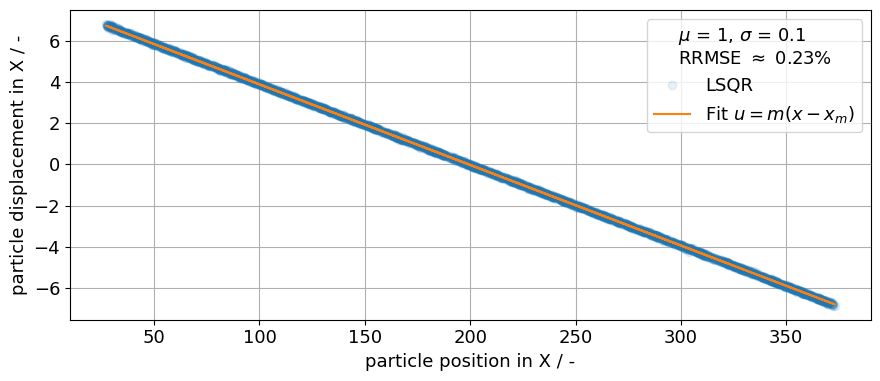

In [15]:
mpl.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(figsize=(9,4))

ax.plot(pos[solvedir], xkk_la, "o", alpha=0.1, label="LSQR")
ax.plot(pos[solvedir], xkk_fit, label="Fit $u=m(x-x_m)$")

ax.set_xlabel("particle position in %s / -" % (dirnames[solvedir]))
ax.set_ylabel("particle displacement in %s / -" % (dirnames[solvedir]))
ax.grid(True)
ax.legend(title="$\mu$ = %.2g, $\sigma$ = %.2g\nRRMSE $\\approx$ %.2g%%" % (mu, sigma, RRMSE*100))
fig.tight_layout()

Here we see that as written in the paper, a full least-squares solution of the model gives a linear function of position. This also directly predicts homogeneous densification across the entire green body, as one would expect when there are no local influences.

Let's include what the nearest-neighbour-interactions-only model, as proposed by Wang in 2006, predicts for the displacements:

In [16]:
s = nearestNeighboursOnly(contacts, pos, rhsspread=sigma,  posdep=posdep) 
# calculates the solution if only direct neighbours are assumed
# to contribute to the solution, i.e. similar to Wang's original 2006 paper

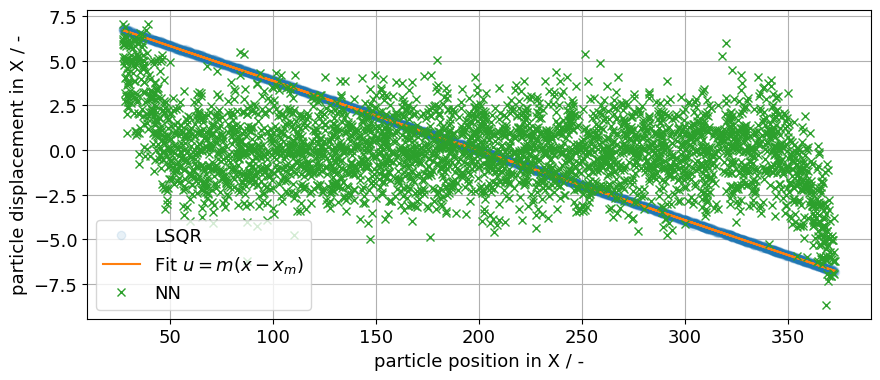

In [17]:
fig, ax = plt.subplots(figsize=(9,4))

ax.plot(pos[solvedir], xkk_la, "o", alpha=0.1, label="LSQR")
ax.plot(pos[solvedir], xkk_fit, label="Fit $u=m(x-x_m)$")
ax.plot(pos[solvedir], s[solvedir], "x", label="NN") 

ax.set_xlabel("particle position in %s / -" % (dirnames[solvedir]))
ax.set_ylabel("particle displacement in %s / -" % (dirnames[solvedir]))
ax.grid(True)
ax.legend()
fig.tight_layout()

Here we can see that basically only the outer edges experience densification, since the divergence of displacement div(u) is non-zero only for the edges. Within the green body proper div(u) is on average zero between volume elements, which means no densification occurs. Furthermore, there's a significant amount of particles close to the surface which actually would move *towards* the surface instead further inwards (negative displacement for x < 200 and v.v. for x > 200).

We'll now first compare the obtained profile for the NN model to results from Seiz's 2023 paper, followed by approximating div(u) between volume elements.

The data for an early condition of the (400^3, R=12nm) simulation is loaded in the following and compared to our present results for the NN model. Thus the position of the particles will be a bit off, but that doesn't impact the shape too much.

Note that the velocity is actually in physical units but we don't use any units in this notebook --- therefore only the shape of the profile can be reasonably compared. It doesn't matter that it's a velocity since the instantaneous displacement as calculated here and the instantaneous velocity are linearly related and therefore the curve shape does not change.

In [18]:
posvel = np.loadtxt("pos-velo.dat") # this is just for the 400^3 R=12nm simulation
# both in physical units (nm, um/s) but luckily the nm-scale fits with scale employed in the position data
fig, ax = plt.subplots()
cols = plt.rcParams["axes.prop_cycle"].by_key()["color"]
ax2 = ax.twinx()
alphaval=0.25
ax.grid(True)
ax.scatter(pos[X], s[X], color=cols[0], alpha=alphaval)
ax2.scatter(posvel[0,:], posvel[1,:], color=cols[1], alpha=alphaval)
ax.set_xlabel("particle position / -")
ax.set_ylabel("particle displacement / -")
ax2.set_ylabel("particle velocity / -")

ax.scatter([], [], color=cols[0], label="NN disp.", alpha=alphaval)
ax.scatter([], [], color=cols[1], label="Seiz2023 vel.", alpha=alphaval)
ax.legend()

fig.tight_layout()

The divergence of displacement div(u) between volume elements can be approximated by binning the displacements along a coordinate, following by differentiating the newly generated data. Note that this assumes we're solving in the X direction for the 400^3 R=12nm case, so please re-execute the solves above if you have some other data.

We will compare the nearest-neighbours (NN) model and the MD-inspired (MDi) model, calculated with the full least-squares solution via LSQR.

In [19]:
solvedir=X 
xmin, xmax = np.min(pos[solvedir]), np.max(pos[solvedir])
bincount = 25
binedges = np.linspace(xmin, xmax, bincount)
bins = []
binpos = []
labs = ["MDi", "NN"]
dats = {"MDi": xkk_la, "NN": s[solvedir]}
ubinned = {"MDi": [], "NN": []}
for i in range(bincount-1):
    bmin, bmax = binedges[i], binedges[i+1]
    binpos.append(0.5*(bmax+bmin))
    filt = (pos[solvedir] > bmin) & (pos[solvedir] <= bmax)
    for lab in labs:
        umean = np.average(dats[lab][filt])
        ubinned[lab].append(umean)

In [20]:
divus = {}
for lab in labs:
    divu = np.gradient(ubinned[lab], binpos)
    divus[lab] = divu

In [21]:
fig, ax = plt.subplots()
ax.grid(True)
for lab in labs:
    ax.plot(binpos, divus[lab], label=lab)
ax.legend()
ax.set_xlabel("bin position in x / -")
ax.set_ylabel("div(u) ~ strain / -")
fig.tight_layout()

In which we indeed observe that the nearest-neighbour (NN) model only predicts negative strain = shrinkage in the outer layers, with no significant shrinkage in the bulk part. Model MDi gets roughly constant strain across the entire green body; note that the full solution is used for this, so the linear fit ansatz is validated again.

An easy visualization for the individual displacements is available for 2D packings, showing the particle positions and their displacement vectors. While also doable for 3D, the third coordinate gets lost in the 2D presentation.

If the packing is regular and there is no randomness in the rhs, the displacement vectors will always be aligned to the total center of mass; if some spread/irregularity is allowed, they will still point roughly to the total COM but be off slightly for the LSQR solution. The fit solution enforces the COM orientation by virtue of supposing that the zero-displacement point is the center of mass.

In [22]:
solvedir2 = X
dxx = linalg.lsqr(cmat[solvedir2], r[solvedir2], x0=inis[solvedir2])[0]
dxx -= np.average(dxx) 

solvedir2 = Y
dyy =linalg.lsqr(cmat[solvedir2], r[solvedir2], x0=inis[solvedir2])[0]
dyy -= np.average(dyy) 

fig, ax = plt.subplots()
ax.set_xlabel("x position / -")
ax.set_ylabel("y position / -")
ax.scatter(pos[0], pos[1])

pps = range(totp) if totp < 100 else np.random.randint(0,totp,size=100)
for p in pps:
    dx = dxx[p]
    dy = dyy[p] 
    ax.arrow(pos[0][p], pos[1][p], dx*0.9, dy*0.9, width=.01) 
fig.tight_layout()

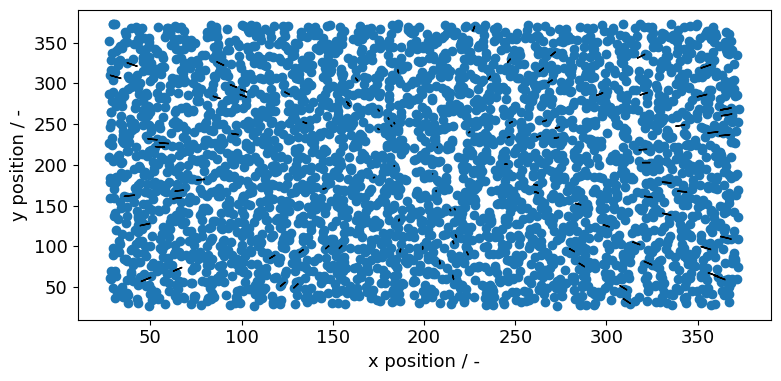

In [23]:
# same thing for fit solution since writing a solver-to-use API seemed overkill for this
solvedir2 = X
dxx = fit_distributed(cmat[solvedir2], r[solvedir2], pos[solvedir2], N=2)
dxx -= np.average(dxx) 

solvedir2 = Y
dyy = fit_distributed(cmat[solvedir2], r[solvedir2], pos[solvedir2], N=2)
dyy -= np.average(dyy) 

fig, ax = plt.subplots()
ax.set_xlabel("x position / -")
ax.set_ylabel("y position / -")
ax.scatter(pos[0], pos[1])

pps = range(totp) if totp < 100 else np.random.randint(0,totp,size=100)
for p in pps:
    dx = dxx[p] 
    dy = dyy[p] 
    ax.arrow(pos[0][p], pos[1][p], dx*0.9, dy*0.9, width=.01)
fig.tight_layout()

One can also use the present model for some additional motion in discrete element methods (DEM). I am not sure whether only the normal particle contact laws for DEM would yield displacement profiles with div(u) < 0; if not, the present model is probably one of the cheaper ways to include it. The rhs used here could then be based on those DEM sintering models for neck growth and saying that some fraction of neck growth happened via a densifying mechanism.